# Nanopore to Wave

As a DNA molecule or fragement passes through the nanopore it causes the voltage potential to vary. This 'signal' is captured by an A to D converter and stored as a 'read'. These reads are stored in an HDF5 (h5, fast5 etc..>) file along with various attributes. The MinION samples at 4kHz with 13 bits while the PromethION samples at 4kHz and 11 bits. In addition to the signal each HDF5 file contains a variety of attributes such as the voltage offset, range etc....

In [1]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wave
import struct

In [2]:
# Look for all fast5 files under the nanopore directory
files = glob.glob(os.path.expanduser("~/data/nanopore/*/*.fast5"))
print(f"Found {len(files)} nanopore h5 files")

Found 38 nanopore h5 files


## Attributes
Dump out all the attributes in the first file found

In [3]:
with h5py.File(files[0], "r") as hdf:
    print(f"Dumping attributes for\n{files[0]}\n")
    # Get the names of all groups and subgroups in the file
    list_of_names = []
    hdf.visit(list_of_names.append)
    attribute = []
    for name in list_of_names:
        # Get all the attribute name and value pairs
        itemL = hdf[name].attrs.items()
        for item in itemL:
            attr, val = item
            if type(hdf[name].attrs[attr]) == np.ndarray:
                val = ''.join(hdf[name].attrs[attr])
            val = str(val).replace('\n', '')
            attribute.append([name+'/'+attr, val])
    # Print the header
    print('{0}'.format('\t'.join(['attribute', 'value'])))
    # Print the attribute list
    print('{0}'.format('\n'.join(
        ['\t'.join([str(x) for x in item]) for item in attribute])))

Dumping attributes for
/Users/rcurrie/data/nanopore/MinION_GM12878/DEAMERNANOPORE_20161117_FNFAB43577_MN16450_sequencing_run_MA_821_R9_4_NA12878_11_17_16_88738_ch119_read41_strand.fast5

attribute	value
Raw/Reads/Read_41/read_number	41
Raw/Reads/Read_41/read_id	b'a5c4c91c-ec48-4feb-81d4-1fe10185095c'
Raw/Reads/Read_41/start_mux	3
Raw/Reads/Read_41/start_time	494759
Raw/Reads/Read_41/duration	25714
Raw/Reads/Read_41/median_before	218.76177625501478
UniqueGlobalKey/channel_id/channel_number	b'119'
UniqueGlobalKey/channel_id/offset	24.0
UniqueGlobalKey/channel_id/digitisation	8192.0
UniqueGlobalKey/channel_id/range	1467.61
UniqueGlobalKey/channel_id/sampling_rate	4000.0
UniqueGlobalKey/context_tags/filename	b'deamernanopore_20161117_fnfab43577_mn16450_sequencing_run_ma_821_r9_4_na12878_11_17_16_88738'
UniqueGlobalKey/context_tags/experiment_kit	b'genomic_dna'
UniqueGlobalKey/context_tags/experiment_type	b'customer_qc'
UniqueGlobalKey/context_tags/user_filename_input	b'ma_821_r9.4_na12878_

## Lengths
Get a sense of the range of read lengths

Durations Min: 4738 Max: 159190 Avg: 55321.76315789474


(array([10.,  6.,  5.,  4.,  4.,  2.,  2.,  1.,  2.,  2.]),
 array([  4738. ,  20183.2,  35628.4,  51073.6,  66518.8,  81964. ,
         97409.2, 112854.4, 128299.6, 143744.8, 159190. ]),
 <a list of 10 Patch objects>)

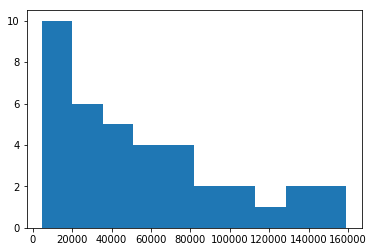

In [4]:
durations = []
for file in files:
    with h5py.File(file, "r") as hdf:
        for read in hdf["Raw/Reads"]:
            durations.append(hdf[f"Raw/Reads/{read}"].attrs["duration"])

print(f"Durations Min: {min(durations)} Max: {max(durations)} Avg: {sum(durations) / len(durations)}")     
plt.hist(durations)

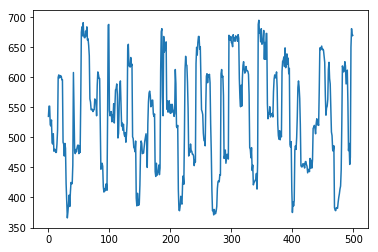

In [5]:
# Plot a bit of the original
with h5py.File(files[0], "r") as hdf:
    signal = hdf.get(f"Raw/Reads/Read_41/Signal")
    plt.plot(range(500), signal[3000:3500])

## Read to Wave
Convert each read into a wave file and store next to the HDF5 file with the read number and .wav suffix.

In [7]:
for file in files:
    with h5py.File(file, "r") as hdf:
        for read in hdf["Raw/Reads"]:
            read_id = hdf[f"Raw/Reads/{read}"].attrs["read_id"].decode()
            read_number = hdf[f"Raw/Reads/{read}"].attrs["read_number"]
            print(f"Exporting {os.path.basename(file)} read {read_number}")
            with wave.open(f"{file.split('.')[0]}_{read_number}.wav", "wb") as wvf:
                signal = hdf.get(f"Raw/Reads/{read}/Signal")
                wvf.setnchannels(1)
                wvf.setframerate(hdf["UniqueGlobalKey/channel_id"].attrs["sampling_rate"])
                wvf.setsampwidth(2)
                wvf.setcomptype('NONE','NONE')
                wvf.writeframes(b''.join([struct.pack('<h',x) for x in signal]))
                wvf.close()

Exporting DEAMERNANOPORE_20161117_FNFAB43577_MN16450_sequencing_run_MA_821_R9_4_NA12878_11_17_16_88738_ch119_read41_strand.fast5 read 41
Exporting DEAMERNANOPORE_20161117_FNFAB43577_MN16450_sequencing_run_MA_821_R9_4_NA12878_11_17_16_88738_ch128_read268_strand.fast5 read 268
Exporting DEAMERNANOPORE_20161117_FNFAB43577_MN16450_sequencing_run_MA_821_R9_4_NA12878_11_17_16_88738_ch128_read793_strand.fast5 read 793
Exporting DEAMERNANOPORE_20161117_FNFAB43577_MN16450_sequencing_run_MA_821_R9_4_NA12878_11_17_16_88738_ch17_read1282_strand.fast5 read 1282
Exporting DEAMERNANOPORE_20161117_FNFAB43577_MN16450_sequencing_run_MA_821_R9_4_NA12878_11_17_16_88738_ch213_read85_strand.fast5 read 85
Exporting DEAMERNANOPORE_20161117_FNFAB43577_MN16450_sequencing_run_MA_821_R9_4_NA12878_11_17_16_88738_ch218_read462_strand.fast5 read 462
Exporting DEAMERNANOPORE_20161117_FNFAB43577_MN16450_sequencing_run_MA_821_R9_4_NA12878_11_17_16_88738_ch236_read921_strand.fast5 read 921
Exporting DEAMERNANOPORE_20161

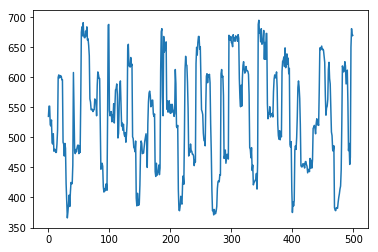

In [8]:
# Plot the wav to make sure its identical
from scipy.io import wavfile
fs, data = wavfile.read(f"{files[0].split('.')[0]}_41.wav")
plt.plot(range(500), data[3000:3500])